In [2]:
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer

Using TensorFlow backend.


In [3]:
# read in data

sdh_notes = pd.read_csv("combined_final_neg.csv")

print("Dataset shape", sdh_notes.shape)

from sklearn.model_selection import train_test_split

train, test = train_test_split(sdh_notes, test_size=0.2, shuffle=True)
print("Records in training set:",len(train))
print("Records in test set:",len(test))

Dataset shape (4063, 11)
Records in training set: 3250
Records in test set: 813


In [4]:
# this function receives comments and returns clean word-list
def clean_doc(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # convert letters to lower case
    
    tokens = [token.lower() for token in tokens]
    #stem tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token.lower()) for token in tokens]
    # tokens = stemmer.stem(tokens.lower())
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    
    #add words that aren't in the NLTK stopwords list
    new_stopwords = ['&loz', 'loz', 'grammarmetadatabegin']
    new_stopwords_list = stop_words.union(new_stopwords)
    
    tokens = [token for token in tokens if token not in stop_words]
    # remove short words (one letter)
    tokens = [token for token in tokens if len(token) > 1]
    # lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token,"v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [5]:
# preprocess all comment texts in the trainning set and testing set
train_text = train.RPT_TEXT.copy()
test_text = test.RPT_TEXT.copy()
train_text_clean = [clean_doc(comment) for comment in train_text]
test_text_clean = [clean_doc(comment) for comment in test_text]
print(len(train_text_clean))
print(len(test_text_clean))
test.to_csv('test_models.csv')

3250
813


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',  
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1, 4),
    max_features = 2000)
    
word_vectorizer.fit(train_text_clean)
train_features = word_vectorizer.transform(train_text_clean)
test_features = word_vectorizer.transform(test_text_clean)

class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']
Y_features = train[class_names]
X_features = train_features
X_train_features, X_val_features, y_train_features, y_val_features = train_test_split(X_features, Y_features, test_size=0.2, random_state=42)

# print("feature names", feature_names)
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

tfidf_matrix =  word_vectorizer.fit_transform(train_text_clean)
feature_names = word_vectorizer.get_feature_names()

doc = 23
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

# for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#   print(w, s)

In [14]:
doc =6
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])

for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
  print(w, s)

tobacco use smoke statu 0.054094166122322325
need financi resourc strain 0.054094166122322325
social need financi resourc 0.054094166122322325
socioeconom histori marit statu 0.054862840284328834
histori socioeconom histori marit 0.054862840284328834
social histori socioeconom histori 0.054862840284328834
social histori social histori 0.05099231287417595
md locat main unch 0.12940584843215902
locat main unch servic 0.18741617966944904
histori procedur later date 0.04682557526077058
surgic histori procedur later 0.04665946717297865
past surgic histori procedur 0.04665946717297865
histori past surgic histori 0.054862840284328834
gerd gastroesophag reflux diseas 0.05527262994632521
medic histori diagnosi date 0.044735008846352016
past medic histori diagnosi 0.044735008846352016
histori past medic histori 0.05023418045083161
medic histori past medic 0.051259541713942855
smokeless tobacco use 0.04976132042112502
smoke statu smoker 0.04976132042112502
use smoke statu 0.054094166122322325
tob

In [7]:
# calculate Precision, recall, ROC

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import multilabel_confusion_matrix 
from sklearn.metrics import classification_report
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def calculateEvalMetrics(Y_test,y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']
    y_score = np.asarray(y_score)

    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
        
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
  
    print('Average precision-recall score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))
  
    roc_val = roc_auc_score(Y_test,y_score)
    print("ROC : {}".format(roc_val*100))
    
    print('Average ROC score, micro-averaged over all SDH classes: {}'
          .format(roc_auc["micro"] *100))
    
    confusion = multilabel_confusion_matrix(Y_test, y_score)
    print("Confusion matrix", confusion)
    
    class_report = classification_report(Y_test, y_score)
    print(class_report)
    
    print("GS",Y_test)
    print("Prediction",y_score)
    
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
    'Average precision score, micro-averaged over all SDH classes: {0:0.2f}'
    .format(average_precision["micro"]))
    
    y_test = pd.DataFrame(Y_test, columns=['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']).to_csv('y_test.csv')
    prediction = pd.DataFrame(y_score, columns=['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']).to_csv('prediction.csv')


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from scipy import interp

def plotROC(y_test,y_score):
    class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']
    n_classes = 6
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = np.asarray(y_score)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for multiple classes')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def plotPrecisionRecallCurve(model, x_test, y_test) :
    from sklearn.metrics import precision_recall_curve
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    probabilities = model.predict_proba(x_test)
    skplt.metrics.plot_precision_recall(y_test, probabilities)
    plt.show()

In [10]:
#Calculate Hamming and Log Loss
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))
    

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 7.9743589743589745
Accuracy : 69.07692307692308
Log_loss : 3.7711008838024713
Average precision-recall score, micro-averaged over all classes: 0.56
ROC : 88.38002642308606
Average ROC score, micro-averaged over all SDH classes: 88.57836716841211
Confusion matrix [[[525  57]
  [  9  59]]

 [[476  54]
  [ 19 101]]

 [[516  43]
  [ 17  74]]

 [[526  38]
  [  7  79]]

 [[557  28]
  [ 16  49]]

 [[580  13]
  [ 10  47]]]
              precision    recall  f1-score   support

           0       0.51      0.87      0.64        68
           1       0.65      0.84      0.73       120
           2       0.63      0.81      0.71        91
           3       0.68      0.92      0.78        86
           4       0.64      0.75      0.69        65
           5       0.78      0.82      0.80        57

   micro avg       0.64      0.84      0.72       487
   macro avg       0.65      0.84      0.73       487
weighted avg       0.6

C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


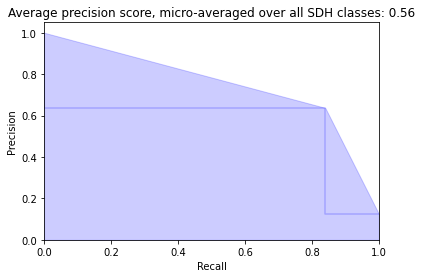

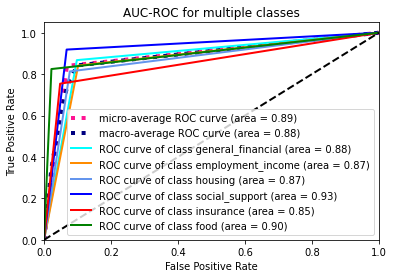

In [15]:
#SVM Classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = BinaryRelevance(classifier = SVC(kernel='linear',class_weight='balanced'), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
# plotPrecisionRecallCurve(classifier, X_val_features, y_val_features)



In [56]:
# feature_names = classifier.get_feature_names()
# print(feature_names)
# class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']

# """Prints features with the highest coefficient values, per class"""
# feature_names = word_vectorizer.get_feature_names()
# for i, class_names in enumerate(class_names):
#     top10 = np.argsort(classifier.coef_attribute[i])[-10:]
#     print("%s: %s" % (class_names,
#               " ".join(feature_names[j] for j in top10)))

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 10.0
Accuracy : 65.07692307692308
Log_loss : 3.0114548647025736
Average precision-recall score, micro-averaged over all classes: 0.30
ROC : 70.0284509944706
Average ROC score, micro-averaged over all SDH classes: 69.37035065282086
Confusion matrix [[[549  37]
  [ 45  19]]

 [[521  28]
  [ 58  43]]

 [[548  30]
  [ 52  20]]

 [[544  27]
  [ 34  45]]

 [[560  21]
  [ 39  30]]

 [[606   6]
  [ 13  25]]]
              precision    recall  f1-score   support

           0       0.34      0.30      0.32        64
           1       0.61      0.43      0.50       101
           2       0.40      0.28      0.33        72
           3       0.62      0.57      0.60        79
           4       0.59      0.43      0.50        69
           5       0.81      0.66      0.72        38

   micro avg       0.55      0.43      0.48       423
   macro avg       0.56      0.44      0.49       423
weighted avg       0.55      0.43    

C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


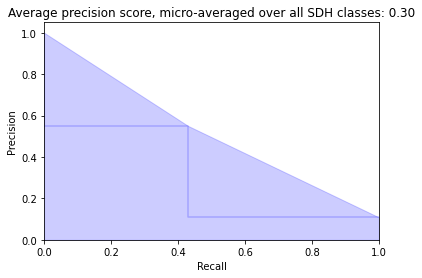

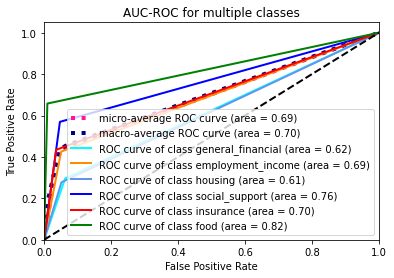

In [57]:
#Multinomial Naive Bayes
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
# plotPrecisionRecallCurve(classifier, X_val_features, y_val_features)

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 4.3076923076923075
Accuracy : 79.6923076923077
Log_loss : 4.303192765060959
Average precision-recall score, micro-averaged over all classes: 0.69
ROC : 88.37707380278131
Average ROC score, micro-averaged over all SDH classes: 88.02546888712715
Confusion matrix [[[571   8]
  [ 18  53]]

 [[524  20]
  [ 28  78]]

 [[549  16]
  [ 27  58]]

 [[557  11]
  [ 10  72]]

 [[577   7]
  [ 12  54]]

 [[590   3]
  [  8  49]]]
              precision    recall  f1-score   support

           0       0.87      0.75      0.80        71
           1       0.80      0.74      0.76       106
           2       0.78      0.68      0.73        85
           3       0.87      0.88      0.87        82
           4       0.89      0.82      0.85        66
           5       0.94      0.86      0.90        57

   micro avg       0.85      0.78      0.81       467
   macro avg       0.86      0.79      0.82       467
weighted avg       0.85 

C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


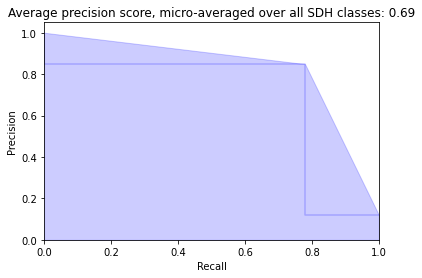

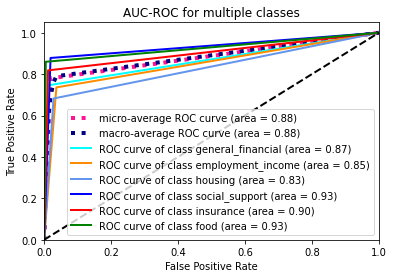

In [11]:
#XGBoost
from skmultilearn.problem_transform import BinaryRelevance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = XGBClassifier(learning_rate=0.5, n_jobs=-1, max_depth=10, scale_pos_weight=1), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)

print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())
#plotPrecisionRecallCurve(classifier)

Start fit...
End fit...
Start predict...
End predict...
Hamming_loss : 8.974358974358974
Accuracy : 65.38461538461539
Log_loss : 4.579535633874003
Average precision-recall score, micro-averaged over all classes: 0.31
ROC : 67.96966605904225
Average ROC score, micro-averaged over all SDH classes: 66.83086625994122
Confusion matrix [[[572  14]
  [ 46  18]]

 [[532  17]
  [ 69  32]]

 [[558  20]
  [ 56  16]]

 [[553  18]
  [ 42  37]]

 [[573   8]
  [ 45  24]]

 [[610   2]
  [ 13  25]]]
              precision    recall  f1-score   support

           0       0.56      0.28      0.38        64
           1       0.65      0.32      0.43       101
           2       0.44      0.22      0.30        72
           3       0.67      0.47      0.55        79
           4       0.75      0.35      0.48        69
           5       0.93      0.66      0.77        38

   micro avg       0.66      0.36      0.46       423
   macro avg       0.67      0.38      0.48       423
weighted avg       0.65 

C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


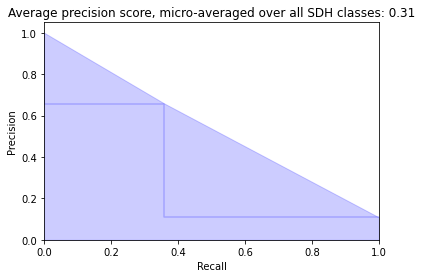

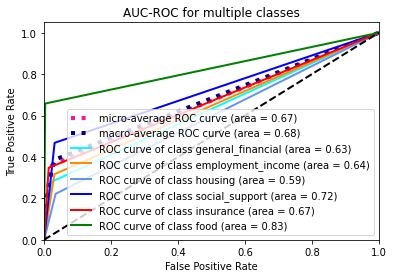

In [59]:
#KNN
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = KNeighborsClassifier(n_neighbors=4, weights='distance'), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())

Start fit...


C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rstem15\Anaconda3\lib\site-packages\sklearn\ensemble\forest

End fit...
Start predict...
End predict...
Hamming_loss : 8.76923076923077
Accuracy : 63.07692307692307
Log_loss : 4.87127509143373
Average precision-recall score, micro-averaged over all classes: 0.30
ROC : 64.90874061970125
Average ROC score, micro-averaged over all SDH classes: 64.9732691221135
Confusion matrix [[[572  14]
  [ 44  20]]

 [[534  15]
  [ 79  22]]

 [[571   7]
  [ 60  12]]

 [[560  11]
  [ 29  50]]

 [[576   5]
  [ 51  18]]

 [[612   0]
  [ 27  11]]]
              precision    recall  f1-score   support

           0       0.59      0.31      0.41        64
           1       0.59      0.22      0.32       101
           2       0.63      0.17      0.26        72
           3       0.82      0.63      0.71        79
           4       0.78      0.26      0.39        69
           5       1.00      0.29      0.45        38

   micro avg       0.72      0.31      0.44       423
   macro avg       0.74      0.31      0.42       423
weighted avg       0.71      0.31      0

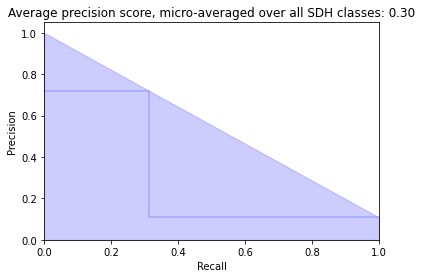

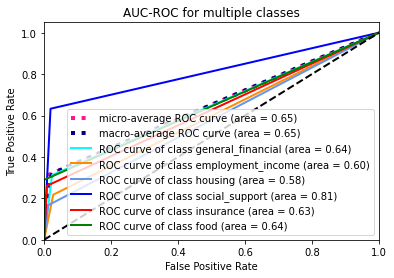

In [60]:
#RF
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
classifier = BinaryRelevance(classifier = RandomForestClassifier(max_depth=10, random_state=0, bootstrap=True), require_dense = [False, True])
print("Start fit...")
classifier.fit(X_train_features, y_train_features)
print("End fit...")
print("Start predict...")
predictions = classifier.predict(X_val_features)
print("End predict...")
evaluate_score(y_val_features,predictions)
calculateEvalMetrics(np.asarray(y_val_features),predictions.todense())
plotROC(np.asarray(y_val_features),predictions.todense())

In [61]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_text_clean)
train_encoded = tokenizer.texts_to_sequences(train_text_clean)
test_encoded = tokenizer.texts_to_sequences(test_text_clean)

#vocabulary size 
print('The vocabulary size is {}.'.format(len(tokenizer.word_index)))

# print("tokenizer items -->",tokenizer.word_index.items())

#length of comment 
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])

The vocabulary size is 8410.
length of encoded comments--> 3250
[418, 122, 1339, 23, 82, 94, 3274, 1060, 3275, 74, 3275, 30, 215, 3274, 30, 303, 332, 104, 38]
length of encoded comments--> 3250
[418, 122, 1339, 23, 82, 94, 3274, 1060, 3275, 74, 3275, 30, 215, 3274, 30, 303, 332, 104, 38]


In [62]:
#get equal length vectors for all the comments 
maxlen = 700
X_train = pad_sequences(train_encoded, maxlen = maxlen, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = maxlen, padding = 'post')

class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']
y_train = train[class_names]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [63]:
# load the whole embedding into memory
def create_embeddings_index(filename):
    embeddings_index = dict()
    f = open(filename, encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index.keys()))
    return embeddings_index

In [64]:
# create a weight matrix for words in training docs (look up word vectors in embeddings_index)
def create_embeddings_matrix(tokenizer, embeddings_index):
   # print("Word index",tokenizer.word_index)
    vocab_size = len(tokenizer.word_index) + 1
    embeddings_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    #print(embeddings_matrix)
    return embeddings_matrix

In [65]:
# GloVe model
# load the whole embedding into memory
embeddings_index_glove = create_embeddings_index('glove.6B.100d.txt')
embeddings_matrix_glove = create_embeddings_matrix(tokenizer, embeddings_index_glove)
print(embeddings_matrix_glove)

Loaded 400000 word vectors.
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.13883001 -0.57112998 -0.45835    ... -0.33215001 -0.32190001
  -0.1498    ]
 [-0.19329     0.16779999  0.12382    ... -0.61945999  0.16678999
  -0.64516997]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.15207     0.43651    -0.34863999 ... -0.21389    -0.266
   0.22832   ]]


In [66]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from keras.layers.convolutional import Conv1D, MaxPooling1D
# define the model
vocab_size = len(tokenizer.word_index) + 1

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights = [embeddings_matrix_glove], input_length = maxlen, trainable = False))
model_glove.add(Bidirectional(LSTM(128, return_sequences=True)))
model_glove.add(GlobalMaxPool1D())
model_glove.add(Dropout(0.25))
model_glove.add(Dense(6, activation="sigmoid"))

In [67]:
# define new callback for ROC AUC score
class roc_callback(Callback):
    from sklearn.metrics import f1_score
    def __init__(self,training_data,validation_data):
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):        
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)      
        
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val) 

        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        
        
        # For each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        class_names = ['general_financial', 'employment_income', 'housing', 'social_support', 'insurance', 'food']
        y_test = np.asarray(y_val)
        y_score = np.asarray(y_pred_val)
        
        H = np.average(y_test*(1-y_score)+(1-y_test)*y_score)
        print(H)


        for i in range(len(class_names)):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                                y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])


        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
            y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score,
                                                             average="micro")

        print('Average precision score, micro-averaged over all classes: {0:0.2f}'
              .format(average_precision["micro"]))
        
        plt.figure()
        plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
        plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(
        'Average precision score, micro-averaged over all SDH classes: {0:0.2f}'
        .format(average_precision["micro"]))
        
        #print(y_pred_val)
        #y_pred_val_np = np.argmax(y_pred_val, axis=1)
        #evaluate_score(np.asarray(y_val),y_pred_val_np)
        #calculateEvalMetrics(np.asarray(y_val),y_pred_val_np.todense())
        plotROC(np.asarray(y_val),y_pred_val)
    
        return

In [68]:
# function that compile, train and evaluate model
def train_model(model,X_train,y_train,X_val,y_val,batch_size,epochs,filepath):
    # compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # parameters 
    batch_size = batch_size
    epochs = epochs

    
    # callbacks
    checkpointer =  ModelCheckpoint(filepath=filepath, 
                                    verbose=1, 
                                    save_best_only=True)
    roc = roc_callback(training_data=(X_train,y_train),validation_data=(X_val,y_val)) 
    print("ROC Callback o/p",roc)
    # fit the model
    history = model.fit(X_train,y_train,
                        validation_data=(X_val,y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc,checkpointer])
    # load the model with the best validation loss
    model.load_weights(filepath)
    return model, history

ROC Callback o/p <__main__.roc_callback object at 0x000001BC06BD8C88>
Train on 2600 samples, validate on 650 samples
Epoch 1/10
2600/2600 [==============================] - 107s 41ms/step - loss: 0.4899 - accuracy: 0.8598 - val_loss: 0.3573 - val_accuracy: 0.8915
roc-auc: 0.4769 - roc-auc_val: 0.4571                                                                                                    
0.20241320627645995
Average precision score, micro-averaged over all classes: 0.11


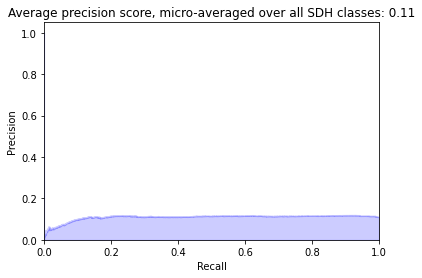

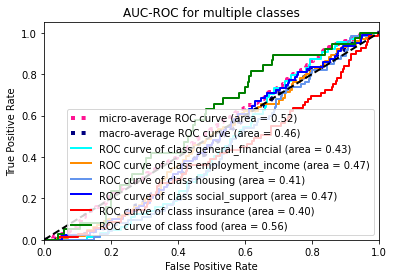


Epoch 00001: val_loss improved from inf to 0.35728, saving model to weights.best.glove.hdf5
Epoch 2/10
2600/2600 [==============================] - 107s 41ms/step - loss: 0.3555 - accuracy: 0.8787 - val_loss: 0.2915 - val_accuracy: 0.8921
roc-auc: 0.7857 - roc-auc_val: 0.7909                                                                                                    
0.17950230203807735
Average precision score, micro-averaged over all classes: 0.36


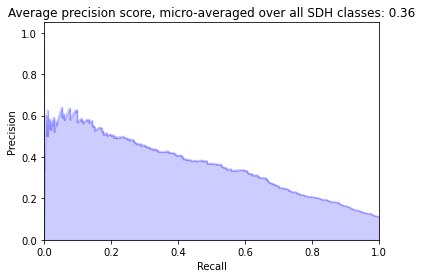

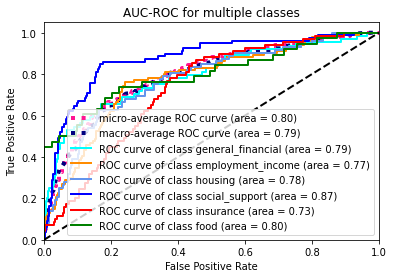


Epoch 00002: val_loss improved from 0.35728 to 0.29151, saving model to weights.best.glove.hdf5
Epoch 3/10
2600/2600 [==============================] - 98s 38ms/step - loss: 0.3057 - accuracy: 0.8800 - val_loss: 0.2631 - val_accuracy: 0.8949
roc-auc: 0.8672 - roc-auc_val: 0.8688                                                                                                    
0.17109842994226476
Average precision score, micro-averaged over all classes: 0.43


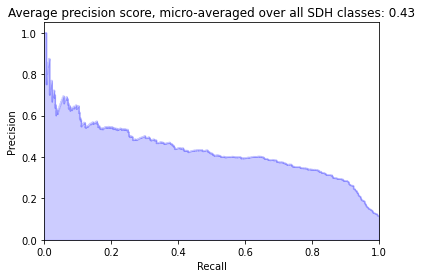

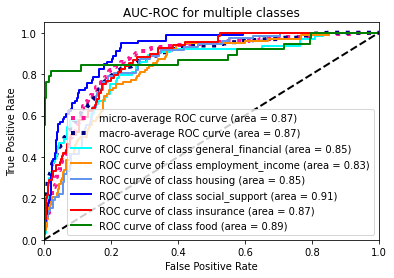


Epoch 00003: val_loss improved from 0.29151 to 0.26309, saving model to weights.best.glove.hdf5
Epoch 4/10
2600/2600 [==============================] - 94s 36ms/step - loss: 0.2751 - accuracy: 0.8851 - val_loss: 0.2415 - val_accuracy: 0.9023
roc-auc: 0.9035 - roc-auc_val: 0.903                                                                                                    
0.16964740876251688
Average precision score, micro-averaged over all classes: 0.54


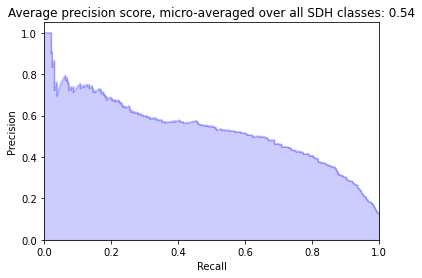

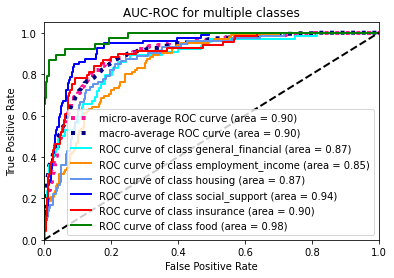


Epoch 00004: val_loss improved from 0.26309 to 0.24149, saving model to weights.best.glove.hdf5
Epoch 5/10
2600/2600 [==============================] - 95s 36ms/step - loss: 0.2620 - accuracy: 0.8919 - val_loss: 0.2354 - val_accuracy: 0.8974
roc-auc: 0.9138 - roc-auc_val: 0.909                                                                                                    
0.13941069373120674
Average precision score, micro-averaged over all classes: 0.60


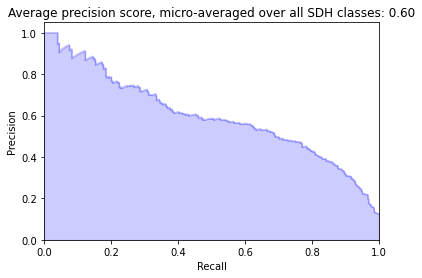

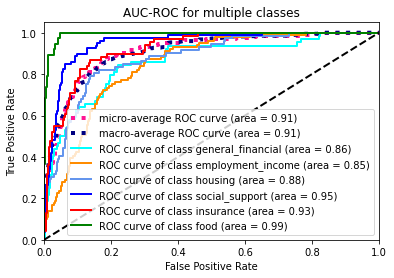


Epoch 00005: val_loss improved from 0.24149 to 0.23541, saving model to weights.best.glove.hdf5
Epoch 6/10
2600/2600 [==============================] - 96s 37ms/step - loss: 0.2388 - accuracy: 0.8997 - val_loss: 0.2115 - val_accuracy: 0.9103
roc-auc: 0.9262 - roc-auc_val: 0.9201                                                                                                    
0.14179343565152241
Average precision score, micro-averaged over all classes: 0.63


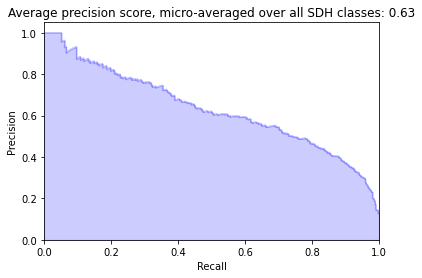

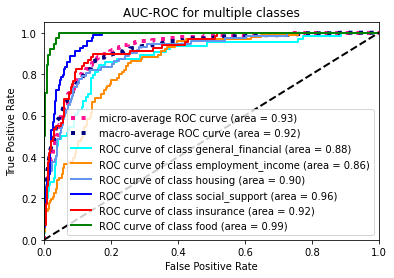


Epoch 00006: val_loss improved from 0.23541 to 0.21151, saving model to weights.best.glove.hdf5
Epoch 7/10
2600/2600 [==============================] - 95s 37ms/step - loss: 0.2232 - accuracy: 0.9071 - val_loss: 0.2033 - val_accuracy: 0.9136
roc-auc: 0.9341 - roc-auc_val: 0.925                                                                                                    
0.1302376440528016
Average precision score, micro-averaged over all classes: 0.64


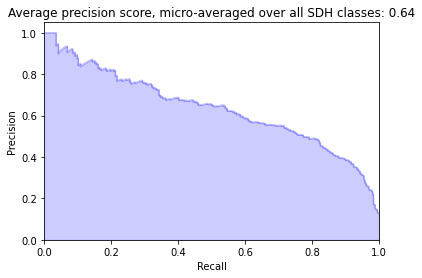

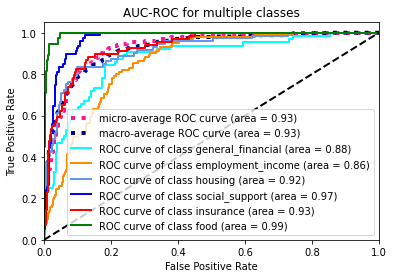


Epoch 00007: val_loss improved from 0.21151 to 0.20326, saving model to weights.best.glove.hdf5
Epoch 8/10
2600/2600 [==============================] - 96s 37ms/step - loss: 0.2094 - accuracy: 0.9128 - val_loss: 0.1931 - val_accuracy: 0.9203
roc-auc: 0.9402 - roc-auc_val: 0.9298                                                                                                    
0.1272624002937347
Average precision score, micro-averaged over all classes: 0.68


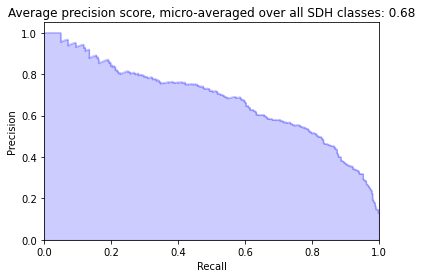

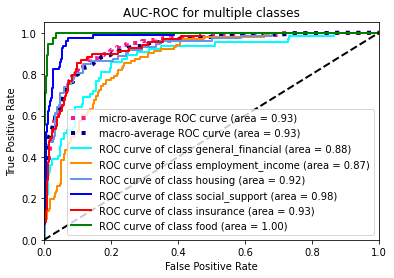


Epoch 00008: val_loss improved from 0.20326 to 0.19307, saving model to weights.best.glove.hdf5
Epoch 9/10
2600/2600 [==============================] - 97s 37ms/step - loss: 0.2043 - accuracy: 0.9141 - val_loss: 0.1901 - val_accuracy: 0.9241
roc-auc: 0.943 - roc-auc_val: 0.9312                                                                                                    
0.12776097785382987
Average precision score, micro-averaged over all classes: 0.70


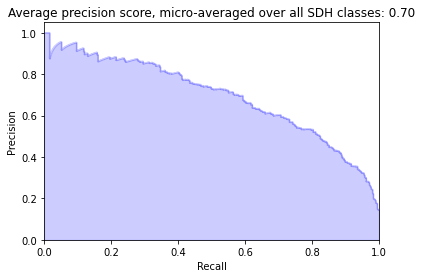

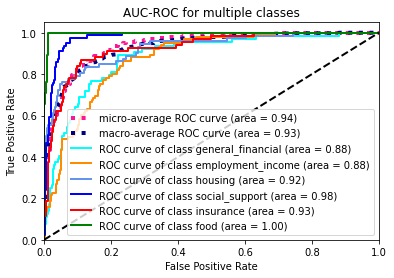


Epoch 00009: val_loss improved from 0.19307 to 0.19011, saving model to weights.best.glove.hdf5
Epoch 10/10
2600/2600 [==============================] - 97s 37ms/step - loss: 0.1922 - accuracy: 0.9240 - val_loss: 0.1805 - val_accuracy: 0.9272
roc-auc: 0.948 - roc-auc_val: 0.9348                                                                                                    
0.1168544452292367
Average precision score, micro-averaged over all classes: 0.70


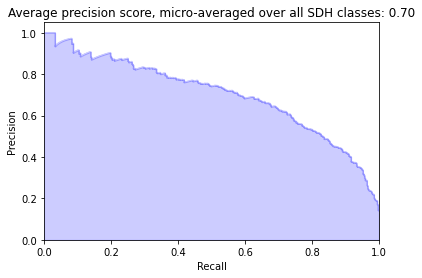

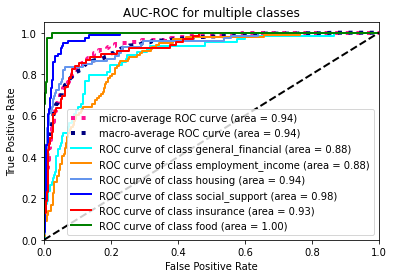


Epoch 00010: val_loss improved from 0.19011 to 0.18049, saving model to weights.best.glove.hdf5


In [69]:
model_glove_trained, history_glove = train_model(model_glove,
                                     X_train,y_train,
                                     X_val,y_val,
                                     batch_size=128, 
                                     epochs=10,
                                     filepath='weights.best.glove.hdf5')

In [45]:


# import matplotlib.pyplot as plt; plt.rcdefaults()
# import numpy as np
# import matplotlib.pyplot as plt
# import itertools

# objects = ('KNN','MultinomialNB', 'XGBoost', 'SVM','LSTM')
# y_pos = np.arange(len(objects))
# performance = [76, 70, 88, 85, 81]

# colors = itertools.cycle(['m','c','y','g','b'])
# for i in range(len(performance)):
#     plt.bar(y_pos[i], performance[i], color=next(colors))

# plt.xticks(y_pos, objects)
# plt.ylabel('ROC')
# plt.title('ROC values for different models')

# plt.show()

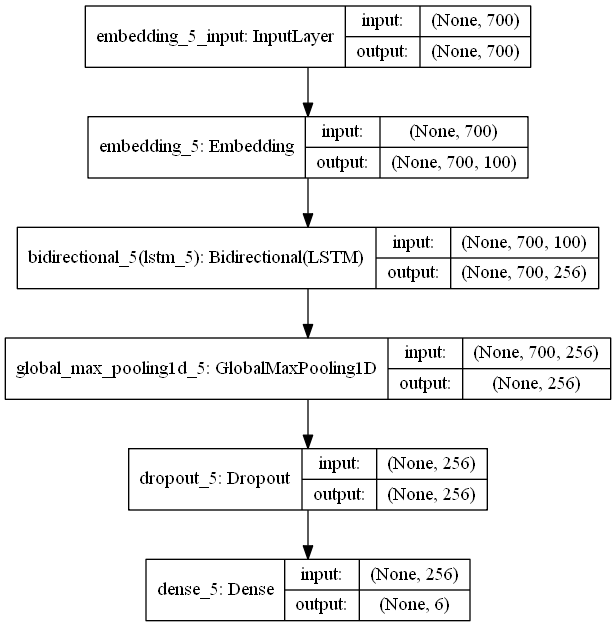

In [302]:
from keras.utils import plot_model
plot_model(model_glove, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)